### Hence, anytime if we will use the variable more than once during operations, we will encounter the bug 
The solutiuon is to accumulate the gradient for variables, every time it repeats, instead of reassignment again, as previouly happened.
Hence, use the "self.grad += *** " instead of "self.grad = ** " , in the backward function

In [1]:
## We have done well for the code, buit we still have a major bug
# Here the Value class has been corrected for the mentioned bug

In [2]:
import math 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [39]:
class Value:
    
    def __init__(self, data, _children=(), _op = '', label = ''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0         # initial value
        self._backward = lambda : None
    def __repr__(self):
        return f"Value(data = {self.data})"
    
    # Note:
    #out = Class(argument, (who are childrem node, again children node), 'name of operation')
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self,other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other):   # (other * self) ; reverse multi to consider "2*a.data" as well 
        return self+other
    
    #def __neg__(self):
     #   return self * -1
    
    def __sub__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data - other.data, (self, other), '-')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += -1.0 * out.grad
        out._backward = _backward
        return out #self + (-other)
    
    #def __rsub__(self, other):
     #   return self - other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    def __rmul__(self, other):   # (other + self) ; reverse multi to consider "2+a.data" as well 
        return self*other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)),   "asserting only int/float powers for now"
        out = Value(self.data**other,(self,), f'**{other}')
        
        def _backward():
            self.grad += (other)*(self.data**((other - 1.0)))*out.grad
        out._backward = _backward
        return out
        
    def __truediv__(self, other):
        out = Value(self.data * other.data**-1,  (self, other), '/')
        out = Value(self.data / other.data,  (self, other), '/')
        def _backward():
            self.grad += (1.0/other.data)*out.grad
            other.grad += (-1.0*self.data/(other.data**2))*out.grad
        out._backward = _backward
        return out #self * other**-1
    
    def __rtruediv__(self, other):
        return self/other
    
    def tanh(self):
        x = self.data
        t = (np.exp(x) - np.exp(-x))/ (np.exp(x) + np.exp(-x))
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward    
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        
        def _backward():
            self.grad = out.data * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        
        topo = []     # empty list to be appended with the children nodes
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)       
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

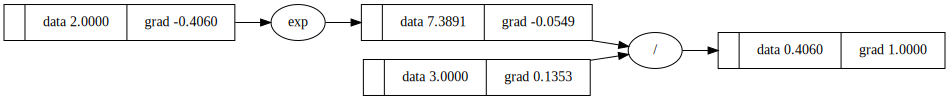

In [40]:
a = Value(2.0)
f = Value(3.0)
b = f / a.exp()
b.backward()
draw_dot(b)

In [41]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format = 'svg', graph_attr = {'rankdir': 'LR'})   # LR = Left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" %(n.label ,n.data, n.grad ), shape = 'record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:   
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

In [42]:
'''# Now it must be correct: as the derivative of a will return as "2"
a = Value(3.0, label = 'a')
b = a + a; b.label ='b'
b.backward()
draw_dot(b)'''

'# Now it must be correct: as the derivative of a will return as "2"\na = Value(3.0, label = \'a\')\nb = a + a; b.label =\'b\'\nb.backward()\ndraw_dot(b)'

#### Now, we will tackle another problem, i.e. breaking down the function like "tanh", and such that backpropogation is possible even if the exact derivative expression is unknown

In [43]:
# Also, lets look the problem of being able to add a simple object to integer
'''a = Value(2.0)
    a +1'''

'a = Value(2.0)\n    a +1'

In [44]:
# alter with this code in the operation function of class
'''other = other if isinstance(other, Value) else Value(other)'''

'other = other if isinstance(other, Value) else Value(other)'

In [45]:
'''a = Value(2.0)
a +1
# done'''

'a = Value(2.0)\na +1\n# done'

In [46]:
# lets break the "tanh fucntion into little pieces"

In [47]:
# Input nodes
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
# weights
w1 = Value(-3.0, label ='w1')
w2 = Value(1.0, label = 'w2')
# bias
b = Value(6.881847283479823, label = 'b')
# forward propogation of input nodes
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp(); e.label = 'e'
o = (e-1)/(e+1)
# ----
#o = n.tanh()
o.label = 'o'
o.backward()

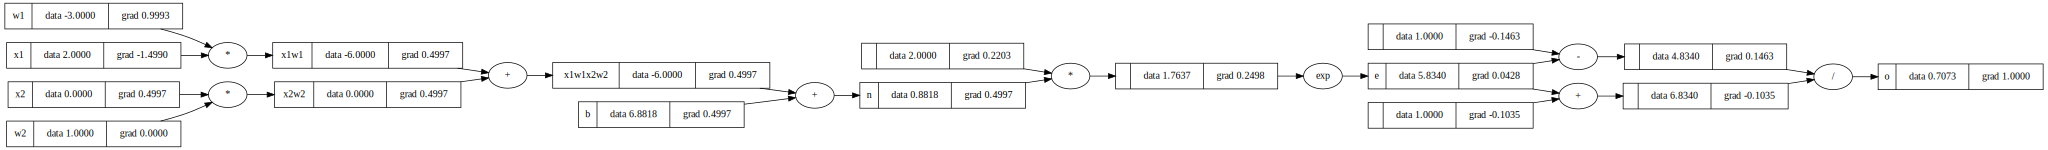

In [48]:
draw_dot(o)